# Overfitting and Regularisation

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.options.mode.chained_assignment = None  # default='warn'

## Bias vs. Variance

see here [–ö–æ–º–ø—Ä–æ–º—ñ—Å –∑—Å—É–≤—É —Ç–∞ –¥–∏—Å–ø–µ—Ä—Å—ñ—ó](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BC%D0%BF%D1%80%D0%BE%D0%BC%D1%96%D1%81_%D0%B7%D1%81%D1%83%D0%B2%D1%83_%D1%82%D0%B0_%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D1%96%D1%97)

[Understanding the bias-variance trade-off !](https://roysubhradip.hashnode.dev/understanding-the-bias-variance-trade-off)

<p align="center">
  <img src="./data/model_complexity.webp" alt="Bias-Variance Tradeoff" width="500"/>
</p>


## Overfitting

see here [Underfitting vs. Overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

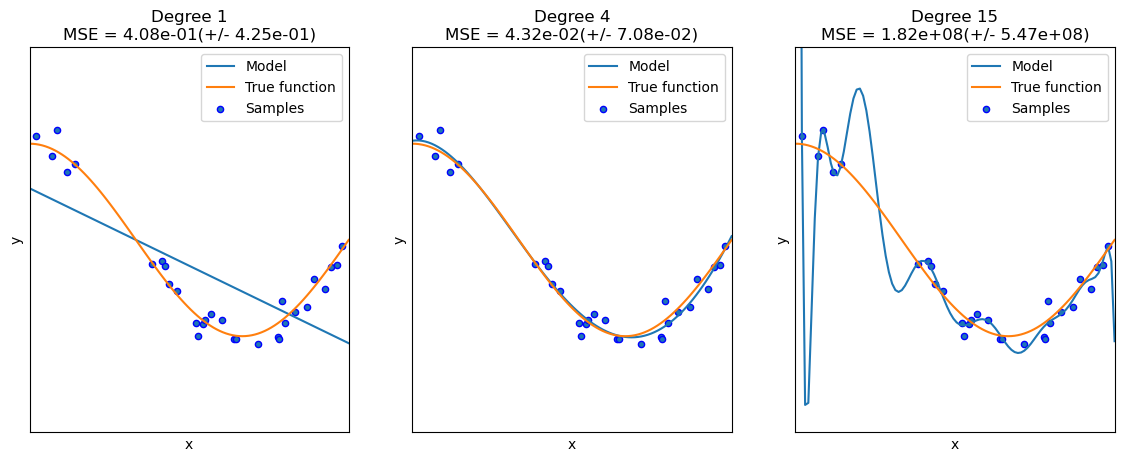

In [3]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

## Train-test split

we will use the Kaggle Food Demand Forecasting data to demonstrate these major steps.
- Data https://kaggle.com/datasets/kannanaikkal/food-demand-forecasting/

In [4]:
# Import data from kaggle competition
PATH = "./data/food_demand"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
# test_data = pd.read_csv(os.path.join(PATH, "test.csv"), index_col=0)

meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(
    drop=False  # —Å—Ç–∞—Ä–∏–π —ñ–Ω–¥–µ–∫—Å –Ω–µ –±—É–¥–µ –≤–∏–¥–∞–ª–µ–Ω–æ, –∞ –±—É–¥–µ –ø–µ—Ä–µ—Ç–≤–æ—Ä–µ–Ω–∏–π —É –∑–≤–∏—á–∞–π–Ω–∏–π —Å—Ç–æ–≤–ø–µ—Ü—å DataFrame.
)

meal_info_df[["category", "meal_id"]].groupby(["category"]).count()
df = df.merge(meal_info_df, on="meal_id", how="left")

df.head()

week  center_id  meal_id  ...  num_orders   category  cuisine
0     1         55     1885  ...         177  Beverages     Thai
1     1         55     1993  ...         270  Beverages     Thai
2     1         55     2539  ...         189  Beverages     Thai
3     1         55     2139  ...          54  Beverages   Indian
4     1         55     2631  ...          40  Beverages   Indian

[5 rows x 10 columns]

In [5]:
df.tail()

week  center_id  meal_id  ...  num_orders  category  cuisine
456543   145         61     1543  ...          68    Desert   Indian
456544   145         61     2304  ...          42    Desert   Indian
456545   145         61     2664  ...         501     Salad  Italian
456546   145         61     2569  ...         729     Salad  Italian
456547   145         61     2490  ...         162     Salad  Italian

[5 rows x 10 columns]

In [6]:
df.cuisine.unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [7]:
# –í–∏–±–∏—Ä–∞—î–º–æ –∑–∞–º–æ–≤–ª–µ–Ω–Ω—è –∑ –º–∞–≥–∞–∑–∏–Ω—É –∑ ID 55, —è–∫—ñ —Å—Ç–æ—Å—É—é—Ç—å—Å—è —Ç–∞–π—Å—å–∫–æ—ó –∫—É—Ö–Ω—ñ
df_slice = df[(df["center_id"] == 55) & (df["cuisine"] == "Thai")]
df_slice = df_slice[["checkout_price", "num_orders"]]

# sorted by checkout_price
df_slice = df_slice.sort_values(by="checkout_price", ascending=False, axis=0)
df_slice.reset_index(
    drop=True,  #  –°–∫–∏–¥–∞—î–º–æ —Å—Ç–∞—Ä–∏–π —ñ–Ω–¥–µ–∫—Å
    inplace=True,  # —ñ —Å—Ç–≤–æ—Ä—é—î–º–æ –Ω–æ–≤–∏–π –ø–æ—Å–ª—ñ–¥–æ–≤–Ω–∏–π —ñ–Ω–¥–µ–∫—Å (0, 1, 2, ...), –Ω–µ –∑–±–µ—Ä—ñ–≥–∞—é—á–∏ —Å—Ç–∞—Ä–∏–π —è–∫ –æ–∫—Ä–µ–º—É –∫–æ–ª–æ–Ω–∫—É
)
df_slice

checkout_price  num_orders
0             321.13          26
1             321.13          41
2             321.13          26
3             321.13          15
4             321.13          28
...              ...         ...
1274           80.54          55
1275           80.54          53
1276           80.54          54
1277           79.54          55
1278           79.54          53

[1279 rows x 2 columns]

In [8]:
# train-test-split with sklearn
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_slice, shuffle=False, test_size=0.25)
train_data.tail()

checkout_price  num_orders
954           146.5          68
955           146.5         285
956           146.5         204
957           146.5          82
958           146.5          94

In [9]:
test_data.head()

checkout_price  num_orders
959           146.5          94
960           146.5         284
961           146.5         121
962           146.5         163
963           146.5         203

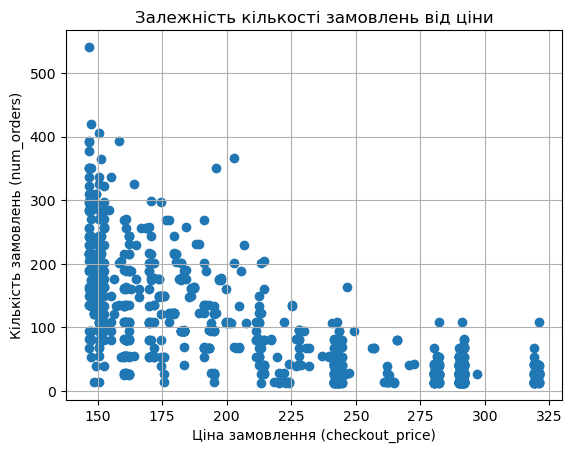

In [10]:
plt.scatter(train_data["checkout_price"], train_data["num_orders"])
plt.xlabel("–¶—ñ–Ω–∞ –∑–∞–º–æ–≤–ª–µ–Ω–Ω—è (checkout_price)")
plt.ylabel("–ö—ñ–ª—å–∫—ñ—Å—Ç—å –∑–∞–º–æ–≤–ª–µ–Ω—å (num_orders)")
plt.title("–ó–∞–ª–µ–∂–Ω—ñ—Å—Ç—å –∫—ñ–ª—å–∫–æ—Å—Ç—ñ –∑–∞–º–æ–≤–ª–µ–Ω—å –≤—ñ–¥ —Ü—ñ–Ω–∏")
plt.grid(True)
plt.show()

In [11]:
# –ß–æ–º—É –Ω–µ —Ç—Ä–µ–±–∞ –¥–∏–≤–∏—Ç–∏—Å—å –Ω–∞ –≥—Ä–∞—Ñ—ñ–∫ —ñ–∑ test_data?
# –Ø–∫—â–æ —Ç–∏ —Ä–æ–±–∏—à –≥—Ä–∞—Ñ—ñ–∫ –∞–±–æ –∞–Ω–∞–ª—ñ–∑ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–∏—Ö –¥–∞–Ω–∏—Ö –ø–µ—Ä–µ–¥ —Ç–∏–º, —è–∫ –ø–æ–±—É–¥—É–≤–∞–≤ –º–æ–¥–µ–ª—å, —Ç–æ —Ü–µ –Ω–æ—Ä–º–∞–ª—å–Ω–æ ‚Äî —Ü–µ —è–∫ "–∫–æ–Ω—Ç—Ä–æ–ª—å–Ω–∞ –ø–µ—Ä–µ–≤—ñ—Ä–∫–∞".

# –ê–ª–µ —è–∫—â–æ —Ç–∏ –¥–∏–≤–∏—à—Å—è –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ñ –¥–∞–Ω—ñ, —â–æ–± –Ω–∞–ª–∞—à—Ç–æ–≤—É–≤–∞—Ç–∏ –º–æ–¥–µ–ª—å –∞–±–æ —Ä–æ–±–∏—à –∞–Ω–∞–ª—ñ–∑, —è–∫–∏–π –ø–æ—Ç—ñ–º –≤–ø–ª–∏–≤–∞—î –Ω–∞ —Ç—Ä–µ–Ω—É–≤–∞–Ω–Ω—è ‚Äî —Ç–∏ "–¥–∏–≤–∏—à—Å—è —É –º–∞–π–±—É—Ç–Ω—î", —ñ —Ü–µ —î –≤–∏—Ç—ñ–∫ –¥–∞–Ω–∏—Ö.

# –¢–æ–±—Ç–æ, —Ç–µ—Å—Ç–æ–≤—ñ –¥–∞–Ω—ñ –º–∞—é—Ç—å –±—É—Ç–∏ "—á–∏—Å—Ç–∏–º–∏", –Ω–µ –≤—ñ–¥–æ–º–∏–º–∏ –º–æ–¥–µ–ª—ñ –¥–æ –∫—ñ–Ω—Ü—è —Ç—Ä–µ–Ω—É–≤–∞–Ω–Ω—è.


# plt.scatter(test_data["checkout_price"], test_data["num_orders"])
# plt.xlabel("–¶—ñ–Ω–∞ –∑–∞–º–æ–≤–ª–µ–Ω–Ω—è (checkout_price)")
# plt.ylabel("–ö—ñ–ª—å–∫—ñ—Å—Ç—å –∑–∞–º–æ–≤–ª–µ–Ω—å (num_orders)")
# plt.title("–ó–∞–ª–µ–∂–Ω—ñ—Å—Ç—å –∫—ñ–ª—å–∫–æ—Å—Ç—ñ –∑–∞–º–æ–≤–ª–µ–Ω—å –≤—ñ–¥ —Ü—ñ–Ω–∏")
# plt.grid(True)
# plt.show()

<h3>–ö–æ—Ä–æ—Ç–∫–∞ —ñ–Ω—Å—Ç—Ä—É–∫—Ü—ñ—è, —â–æ–± —É–Ω–∏–∫–Ω—É—Ç–∏ Data Leakage</h3>
<ol>
  <li><strong>–ß—ñ—Ç–∫–æ —Ä–æ–∑–¥—ñ–ª—è–π –¥–∞–Ω—ñ –Ω–∞ —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω—ñ (train) —ñ —Ç–µ—Å—Ç–æ–≤—ñ (test)</strong> –æ–¥—Ä–∞–∑—É, –¥–æ –±—É–¥—å-—è–∫–∏—Ö –æ–ø–µ—Ä–∞—Ü—ñ–π –∑ –¥–∞–Ω–∏–º–∏.</li>
  <li><strong>–í–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–π —Ç–µ—Å—Ç–æ–≤—ñ –¥–∞–Ω—ñ –ª–∏—à–µ –¥–ª—è —Ñ—ñ–Ω–∞–ª—å–Ω–æ—ó –æ—Ü—ñ–Ω–∫–∏ –º–æ–¥–µ–ª—ñ</strong>, –ø—ñ—Å–ª—è —Ç–æ–≥–æ, —è–∫ –º–æ–¥–µ–ª—å –ø–æ–≤–Ω—ñ—Å—Ç—é –Ω–∞–≤—á–µ–Ω–∞ —ñ –Ω–∞–ª–∞—à—Ç–æ–≤–∞–Ω–∞.</li>
  <li><strong>–ù–µ –¥–∏–≤–∏—Å—å, –Ω–µ –∞–Ω–∞–ª—ñ–∑—É–π —ñ –Ω–µ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–π —ñ–Ω—Ñ–æ—Ä–º–∞—Ü—ñ—é –∑ —Ç–µ—Å—Ç–æ–≤–∏—Ö –¥–∞–Ω–∏—Ö –ø—ñ–¥ —á–∞—Å –Ω–∞–≤—á–∞–Ω–Ω—è –∞–±–æ –ø—ñ–¥–±–æ—Ä—É –ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤ –º–æ–¥–µ–ª—ñ.</strong></li>
  <li><strong>–Ø–∫—â–æ —Ä–æ–±–∏—à —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü—ñ—ó –¥–∞–Ω–∏—Ö (–Ω–æ—Ä–º–∞–ª—ñ–∑–∞—Ü—ñ—è, –º–∞—Å—à—Ç–∞–±—É–≤–∞–Ω–Ω—è, –≤—ñ–¥–±—ñ—Ä –æ–∑–Ω–∞–∫),</strong> –Ω–∞–≤—á–∞—Ç–∏ —ó—Ö —Ç—ñ–ª—å–∫–∏ –Ω–∞ —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω–∏—Ö –¥–∞–Ω–∏—Ö —ñ –∑–∞—Å—Ç–æ—Å–æ–≤—É–≤–∞—Ç–∏ –¥–æ —Ç–µ—Å—Ç–æ–≤–∏—Ö.</li>
  <li><strong>–ù–µ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–π—Ç–µ —Ç–µ—Å—Ç–æ–≤—ñ –¥–∞–Ω—ñ –¥–ª—è –≤—ñ–∑—É–∞–ª—ñ–∑–∞—Ü—ñ—ó –ø—ñ–¥ —á–∞—Å –ø—ñ–¥–≥–æ—Ç–æ–≤–∫–∏ –º–æ–¥–µ–ª—ñ</strong> (—â–æ–± —É–Ω–∏–∫–Ω—É—Ç–∏ –ø—ñ–¥—Å–≤—ñ–¥–æ–º–æ–≥–æ –Ω–∞–ª–∞—à—Ç—É–≤–∞–Ω–Ω—è –º–æ–¥–µ–ª—ñ –ø—ñ–¥ –Ω–∏—Ö).</li>
</ol>
<p>–¶–µ –¥–æ–ø–æ–º–æ–∂–µ –æ—Ç—Ä–∏–º–∞—Ç–∏ —Ä–µ–∞–ª—ñ—Å—Ç–∏—á–Ω—É –æ—Ü—ñ–Ω–∫—É —è–∫–æ—Å—Ç—ñ –º–æ–¥–µ–ª—ñ —ñ –∑–∞–ø–æ–±—ñ–≥—Ç–∏ –∑–∞–≤–∏—â–µ–Ω–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º.</p>


In [12]:
from sklearn.linear_model import LinearRegression

x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)

In [13]:
train_data["predictions"] = model.predict(x)
x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

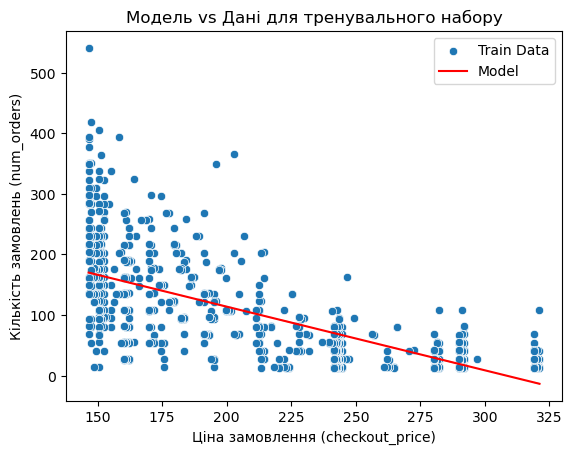

In [14]:
# Train
sns.scatterplot(x="checkout_price", y="num_orders", data=train_data, label="Train Data")
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)
# –î–æ–¥–∞—Ç–∫–æ–≤—ñ –µ–ª–µ–º–µ–Ω—Ç–∏
plt.xlabel("–¶—ñ–Ω–∞ –∑–∞–º–æ–≤–ª–µ–Ω–Ω—è (checkout_price)")
plt.ylabel("–ö—ñ–ª—å–∫—ñ—Å—Ç—å –∑–∞–º–æ–≤–ª–µ–Ω—å (num_orders)")
plt.title("–ú–æ–¥–µ–ª—å vs –î–∞–Ω—ñ –¥–ª—è —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω–æ–≥–æ –Ω–∞–±–æ—Ä—É")
plt.legend()
plt.show()

<Axes: xlabel='checkout_price', ylabel='num_orders'>

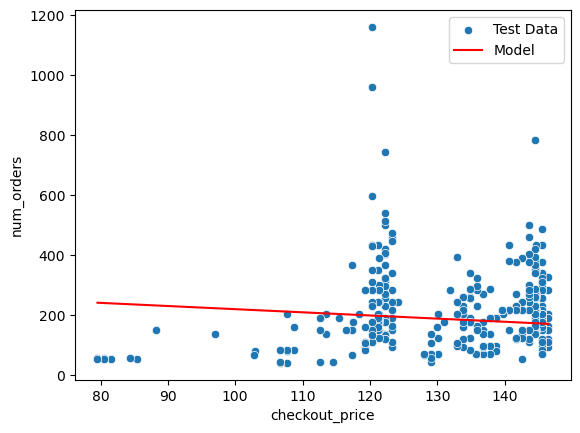

In [15]:
# Test
sns.scatterplot(x="checkout_price", y="num_orders", data=test_data, label="Test Data")
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="red", label="Model"
)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 3621.02
Test MSE: 20190.87


<table>
  <thead>
    <tr>
      <th>–ü—Ä–∏—á–∏–Ω–∞</th>
      <th>–û–∑–Ω–∞–∫–∞</th>
      <th>–†—ñ—à–µ–Ω–Ω—è</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Overfitting</b></td>
      <td>Test MSE ‚â´ Train MSE</td>
      <td>–°–ø—Ä–æ—â–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ, —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—è</td>
    </tr>
    <tr>
      <td><b>–†–æ–∑–±—ñ–∂–Ω—ñ—Å—Ç—å —É Train/Test</b></td>
      <td>Test ‚â† Train —Ä–æ–∑–ø–æ–¥—ñ–ª</td>
      <td>–†–∞–Ω–¥–æ–º—ñ–∑–∞—Ü—ñ—è, –ø–µ—Ä–µ–≤—ñ—Ä–∫–∞ —Ä–æ–∑–ø–æ–¥—ñ–ª—ñ–≤</td>
    </tr>
    <tr>
      <td><b>–ú–∞–ª–æ —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω–∏—Ö –¥–∞–Ω–∏—Ö</b></td>
      <td>–í–∏—Å–æ–∫–∞ –ø–æ—Ö–∏–±–∫–∞ –Ω–∞ —Ç–µ—Å—Ç—ñ</td>
      <td>–ó–±—ñ—Ä –∞–±–æ –≥–µ–Ω–µ—Ä–∞—Ü—ñ—è –Ω–æ–≤–∏—Ö –¥–∞–Ω–∏—Ö</td>
    </tr>
    <tr>
      <td><b>–®—É–º –∞–±–æ –ø–æ–≥–∞–Ω—ñ —Ñ—ñ—á—ñ</b></td>
      <td>–ú–æ–¥–µ–ª—å "–≤–≥–∞–¥—É—î"</td>
      <td>–í—ñ–¥–±—ñ—Ä –æ–∑–Ω–∞–∫ (feature selection)</td>
    </tr>
    <tr>
      <td><b>–ü–æ–≥–∞–Ω–µ –º–∞—Å—à—Ç–∞–±—É–≤–∞–Ω–Ω—è</b></td>
      <td>–í–∏—Å–æ–∫–∏–π MSE</td>
      <td>–°—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∞—Ü—ñ—è/–Ω–æ—Ä–º–∞–ª—ñ–∑–∞—Ü—ñ—è</td>
    </tr>
  </tbody>
</table>


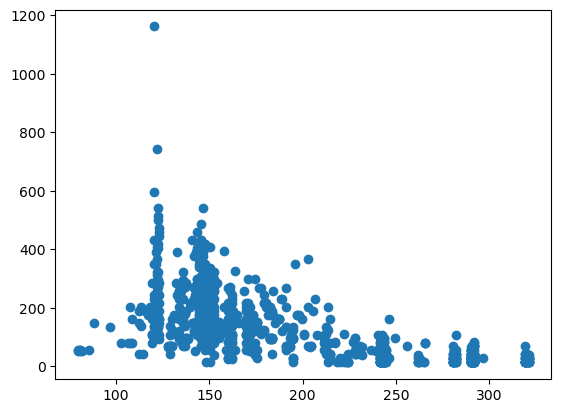

In [17]:
# Shaffle
train_data, test_data = train_test_split(
    df_slice, shuffle=True, test_size=0.25,
)
plt.scatter(
    train_data["checkout_price"], train_data["num_orders"], label="Train Data"
)

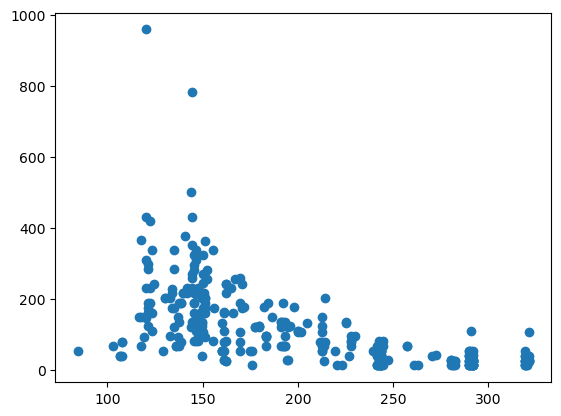

In [18]:
plt.scatter(
    test_data["checkout_price"], test_data["num_orders"], label="Test Data"
)

In [19]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

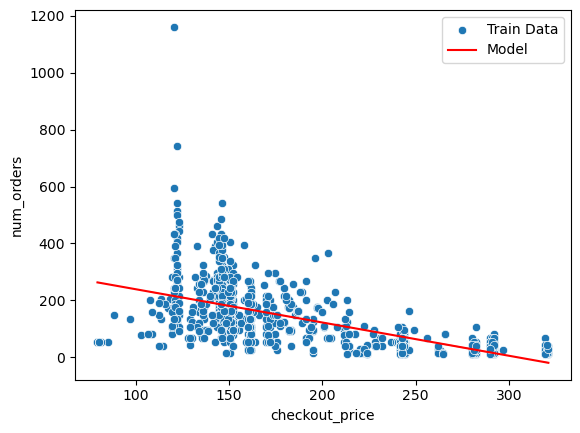

In [20]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=train_data, label="Train Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

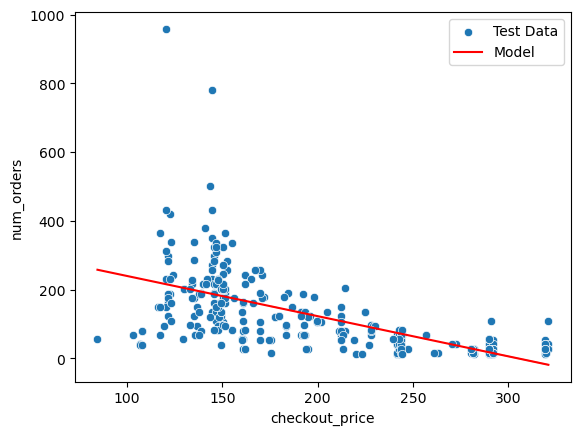

In [21]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="red", label="Model"
)

In [22]:
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 7478.46
Test MSE: 8253.62


<h3>üìà –í–∏—Å–Ω–æ–≤–∫–∏ –ø–æ —è–∫–æ—Å—Ç—ñ –º–æ–¥–µ–ª—ñ</h3>

<ul>
  <li><b>Train MSE:</b> 7478.46</li>
  <li><b>Test MSE:</b> 8253.62</li>
</ul>

<p>‚úÖ <b>–†–µ–∑—É–ª—å—Ç–∞—Ç–∏ —Å–≤—ñ–¥—á–∞—Ç—å –ø—Ä–æ —Ö–æ—Ä–æ—à—É —É–∑–∞–≥–∞–ª—å–Ω—é–≤–∞–Ω—ñ—Å—Ç—å –º–æ–¥–µ–ª—ñ:</b></p>

<ul>
  <li>–ü–æ–º–∏–ª–∫–∏ –Ω–∞ —Ç—Ä–µ–Ω—É–≤–∞–ª—å–Ω–∏—Ö —ñ —Ç–µ—Å—Ç–æ–≤–∏—Ö –¥–∞–Ω–∏—Ö –ø–æ–¥—ñ–±–Ω—ñ ‚Äî <b>–Ω–µ–º–∞—î overfitting</b></li>
  <li>–ú–æ–¥–µ–ª—å –Ω–µ –ø—Ä–æ—Å—Ç–æ –∑–∞–ø–∞–º'—è—Ç–∞–ª–∞ –¥–∞–Ω—ñ, –∞ <b>–Ω–∞–≤—á–∏–ª–∞—Å—è —Ä–æ–±–∏—Ç–∏ –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω–Ω—è</b> –Ω–∞ –Ω–æ–≤–∏—Ö –ø—Ä–∏–∫–ª–∞–¥–∞—Ö</li>
  <li>–†—ñ–∑–Ω–∏—Ü—è –º—ñ–∂ Train —ñ Test MSE —Å—Ç–∞–Ω–æ–≤–∏—Ç—å –º–µ–Ω—à–µ –Ω—ñ–∂ 10% ‚Äî <b>—Ü–µ –¥—É–∂–µ –¥–æ–±—Ä–µ</b></li>
</ul>

<h4>üõ†Ô∏è –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü—ñ—ó:</h4>
<ul>
  <li>–ú–æ–∂–Ω–∞ –¥–æ–¥–∞—Ç–∫–æ–≤–æ –ø—Ä–æ–∞–Ω–∞–ª—ñ–∑—É–≤–∞—Ç–∏ –≤–∞–∂–ª–∏–≤—ñ—Å—Ç—å –æ–∑–Ω–∞–∫ (feature importance)</li>
  <li>–ü–µ—Ä–µ–≤—ñ—Ä–∏—Ç–∏ –∑–∞–ª–∏—à–∫–∏ (residuals), —â–æ–± –∑–Ω–∞–π—Ç–∏, –¥–µ –º–æ–¥–µ–ª—å –Ω–∞–π–±—ñ–ª—å—à–µ –ø–æ–º–∏–ª—è—î—Ç—å—Å—è</li>
  <li>–†–æ–∑–≥–ª—è–Ω—É—Ç–∏ —ñ–Ω—à—ñ –º–µ—Ç—Ä–∏–∫–∏: MAE, R¬≤, MAPE —Ç–æ—â–æ</li>
  <li>–ú–æ–∂–Ω–∞ —Å–ø—Ä–æ–±—É–≤–∞—Ç–∏ –ª–µ–≥–∫–∏–π —Ç—é–Ω—ñ–Ω–≥ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤ –∞–±–æ –∞–Ω—Å–∞–º–±–ª—é–≤–∞–Ω–Ω—è</li>
</ul>


## Cross Validation

https://scikit-learn.org/stable/modules/cross_validation.html

<p align="center">
  <img src="./data/grid_search_cross_validation.png" alt="Cross Validation" width="500"/>
</p>

In [23]:
from sklearn import model_selection

X = range(10)
X

range(0, 10)

In [24]:
kf = model_selection.KFold(n_splits=5)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 4 5 6 7 8 9] TEST: [2 3]
TRAIN: [0 1 2 3 6 7 8 9] TEST: [4 5]
TRAIN: [0 1 2 3 4 5 8 9] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]


In [25]:
kf = model_selection.KFold(n_splits=2, shuffle=True)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)

TRAIN: [0 1 3 5 8] TEST: [2 4 6 7 9]
TRAIN: [2 4 6 7 9] TEST: [0 1 3 5 8]


In [26]:
kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=1)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])

TRAIN: [1 3 5 7 8] TEST: [0 2 4 6 9]
TRAIN labels: [ 96  80 121  80 460]
TEST labels: [ 27  14  15 162 176]
TRAIN: [0 2 4 6 9] TEST: [1 3 5 7 8]
TRAIN labels: [ 27  14  15 162 176]
TEST labels: [ 96  80 121  80 460]


In [27]:
X = range(12)

In [28]:
y = np.array([0] * 6 + [1] * 6)  # 0 for first 6, 1 for next 6
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])

[0 0 0 0 0 0 1 1 1 1 1 1]
TRAIN: [ 0  3  5  7  8 11] TEST: [ 1  2  4  6  9 10]
TRAIN labels: [0 0 0 1 1 1]
TEST labels: [0 0 0 1 1 1]
TRAIN: [ 1  2  4  6  9 10] TEST: [ 0  3  5  7  8 11]
TRAIN labels: [0 0 0 1 1 1]
TEST labels: [0 0 0 1 1 1]


In [29]:
y = np.array([0, 1] * 6)  # 0 for first 6, 1 for next 6
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])
# StratifiedKFold ensures that each fold has the same proportion of classes as the entire dataset.
# This is particularly useful for imbalanced datasets, where one class may be underrepresented.

[0 1 0 1 0 1 0 1 0 1 0 1]
TRAIN: [ 0  3  5  6 10 11] TEST: [1 2 4 7 8 9]
TRAIN labels: [0 1 1 0 0 1]
TEST labels: [1 0 0 1 0 1]
TRAIN: [1 2 4 7 8 9] TEST: [ 0  3  5  6 10 11]
TRAIN labels: [1 0 0 1 0 1]
TEST labels: [0 1 1 0 0 1]


In [30]:
ss = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)

for train_indices, test_indices in ss.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
# ShuffleSplit randomly splits the data into training and testing sets multiple times, without preserving the class distribution.

TRAIN: [ 6  5  8 11  4  1  0  7 10] TEST: [3 9 2]
TRAIN: [ 3 11  6  2  8  9  4  5 10] TEST: [0 1 7]
TRAIN: [ 6  7  5 10  1  9  8  0  3] TEST: [ 2  4 11]
TRAIN: [ 6 11 10  0  4  5  9  3  2] TEST: [7 8 1]
TRAIN: [ 5  7  6 10  0 11  4  1  8] TEST: [2 3 9]
TRAIN: [ 4  7  8  5  6 10  3  0  9] TEST: [ 2 11  1]
TRAIN: [ 9  0 10  3  1  2 11  5  8] TEST: [4 6 7]
TRAIN: [ 4  0  9  1 11  7  2  6  8] TEST: [ 3  5 10]
TRAIN: [ 8  4  9  0  1  2 11  3 10] TEST: [5 7 6]
TRAIN: [ 9  4 10  8  7  1 11  2  3] TEST: [0 6 5]


In [31]:
X = range(10)
target = np.array([0] * 5 + [1] * 5)  # 0 for first 5, 1 for next 5 
print(target)

sss = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.2)
for train_indices, test_indices in sss.split(X, target):
    print("TRAIN:", train_indices, "TEST:", test_indices)

[0 0 0 0 0 1 1 1 1 1]
TRAIN: [2 5 4 1 6 7 9 3] TEST: [8 0]
TRAIN: [4 6 8 7 5 2 0 3] TEST: [9 1]
TRAIN: [7 8 4 6 0 1 3 9] TEST: [2 5]
TRAIN: [9 4 0 2 6 7 8 1] TEST: [5 3]


In [32]:
loo = model_selection.LeaveOneOut()

for train_indices, test_indices in loo.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)

TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


## Regularization
Ridge Regression: in ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.

Classic linear regression:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
$$

**Where:**

- $\hat{y}$ : predicted value (output)  
- $\beta_0$ : intercept (bias term)  
- $\beta_1, \beta_2, \dots, \beta_p$ : model coefficients (weights)  
- $x_1, x_2, \dots, x_p$ : input features (predictors)

---

Sum of squares in classic linear regression:

$$
\text{SSE} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 = \sum_{i=1}^{n} \left( y_i - \sum_{j=0}^{p} w_j x_{ij} \right)^2
$$

$$
\text{SSE} = \sum_{i=1}^{n} \left( y_i - \sum_{j=0}^{p} \beta_j x_{ij} \right)^2
$$

üìå **–ü–æ—è—Å–Ω–µ–Ω–Ω—è:**

- $y_i$ ‚Äî —Ñ–∞–∫—Ç–∏—á–Ω–µ (—Å–ø–æ—Å—Ç–µ—Ä–µ–∂—É–≤–∞–Ω–µ) –∑–Ω–∞—á–µ–Ω–Ω—è  
- $\hat{y}_i$ ‚Äî –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω–µ –∑–Ω–∞—á–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ  
- $w_j$ ‚Äî –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç–∏ –º–æ–¥–µ–ª—ñ (–∞–Ω–∞–ª–æ–≥—ñ—á–Ω–æ $\beta_j$)  
- $x_{ij}$ ‚Äî –∑–Ω–∞—á–µ–Ω–Ω—è j-—ó –æ–∑–Ω–∞–∫–∏ –¥–ª—è i-–≥–æ —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω–Ω—è  
- $p$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å –æ–∑–Ω–∞–∫  
- $n$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω—å

## Lasso
**Lasso-–º–æ–¥–µ–ª—å –º—ñ–Ω—ñ–º—ñ–∑—É—î —Ñ—É–Ω–∫—Ü—ñ—é –≤—Ç—Ä–∞—Ç:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} |w_j|
$$

–¥–µ:
- –ø–µ—Ä—à–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî —Ü–µ –∑–≤–∏—á–∞–π–Ω–∞ —Å–µ—Ä–µ–¥–Ω—å–æ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞ –ø–æ—Ö–∏–±–∫–∞ (MSE)  
- –¥—Ä—É–≥–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî $L_1$-—à—Ç—Ä–∞—Ñ, —è–∫–∏–π —Å–ø—Ä–∏—è—î –æ–±–Ω—É–ª–µ–Ω–Ω—é –¥–µ—è–∫–∏—Ö $w_j$ (–≤—ñ–¥–±—ñ—Ä –æ–∑–Ω–∞–∫)

üìå **–ü–æ—è—Å–Ω–µ–Ω–Ω—è: Lasso-—Ä–µ–≥—Ä–µ—Å—ñ—è**

- $y_i$ ‚Äî —Ñ–∞–∫—Ç–∏—á–Ω–µ (—Å–ø–æ—Å—Ç–µ—Ä–µ–∂—É–≤–∞–Ω–µ) –∑–Ω–∞—á–µ–Ω–Ω—è  
- $\hat{y}_i$ ‚Äî –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω–µ –∑–Ω–∞—á–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ  
- $w_j$ ‚Äî –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç–∏ –º–æ–¥–µ–ª—ñ  
- $x_{ij}$ ‚Äî –∑–Ω–∞—á–µ–Ω–Ω—è j-—ó –æ–∑–Ω–∞–∫–∏ –¥–ª—è i-–≥–æ —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω–Ω—è  
- $p$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å –æ–∑–Ω–∞–∫  
- $n$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω—å  
- $\lambda$ ‚Äî –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó (–≤–∏–∑–Ω–∞—á–∞—î —Å–∏–ª—É —à—Ç—Ä–∞—Ñ—É)  

**Lasso-–º–æ–¥–µ–ª—å –º—ñ–Ω—ñ–º—ñ–∑—É—î —Ñ—É–Ω–∫—Ü—ñ—é –≤—Ç—Ä–∞—Ç:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} |w_j|
$$

–¥–µ:
- –ø–µ—Ä—à–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî —Ü–µ –∑–≤–∏—á–∞–π–Ω–∞ —Å–µ—Ä–µ–¥–Ω—å–æ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞ –ø–æ—Ö–∏–±–∫–∞ (MSE)  
- –¥—Ä—É–≥–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî $L_1$-—à—Ç—Ä–∞—Ñ, —è–∫–∏–π —Å–ø—Ä–∏—è—î –æ–±–Ω—É–ª–µ–Ω–Ω—é –¥–µ—è–∫–∏—Ö $w_j$ (–≤—ñ–¥–±—ñ—Ä –æ–∑–Ω–∞–∫)

## Ridge
**Ridge-–º–æ–¥–µ–ª—å –º—ñ–Ω—ñ–º—ñ–∑—É—î —Ñ—É–Ω–∫—Ü—ñ—é –≤—Ç—Ä–∞—Ç:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} w_j^2
$$

–¥–µ:
- –ø–µ—Ä—à–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî —Ü–µ –∑–≤–∏—á–∞–π–Ω–∞ —Å–µ—Ä–µ–¥–Ω—å–æ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞ –ø–æ—Ö–∏–±–∫–∞ (MSE)  
- –¥—Ä—É–≥–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî $L_2$-—à—Ç—Ä–∞—Ñ, —è–∫–∏–π –∑–º–µ–Ω—à—É—î –≤–µ–ª–∏—á–∏–Ω—É –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç—ñ–≤, –∞–ª–µ –Ω–µ –∑–∞–Ω—É–ª—è—î —ó—Ö


üìå **–ü–æ—è—Å–Ω–µ–Ω–Ω—è: Ridge-—Ä–µ–≥—Ä–µ—Å—ñ—è**

- $y_i$ ‚Äî —Ñ–∞–∫—Ç–∏—á–Ω–µ (—Å–ø–æ—Å—Ç–µ—Ä–µ–∂—É–≤–∞–Ω–µ) –∑–Ω–∞—á–µ–Ω–Ω—è  
- $\hat{y}_i$ ‚Äî –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω–µ –∑–Ω–∞—á–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ  
- $w_j$ ‚Äî –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç–∏ –º–æ–¥–µ–ª—ñ  
- $x_{ij}$ ‚Äî –∑–Ω–∞—á–µ–Ω–Ω—è j-—ó –æ–∑–Ω–∞–∫–∏ –¥–ª—è i-–≥–æ —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω–Ω—è  
- $p$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å –æ–∑–Ω–∞–∫  
- $n$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω—å  
- $\lambda$ ‚Äî –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó (–≤–∏–∑–Ω–∞—á–∞—î —Å–∏–ª—É —à—Ç—Ä–∞—Ñ—É)  

##  Elastic Net
**Elastic Net –º—ñ–Ω—ñ–º—ñ–∑—É—î —Ñ—É–Ω–∫—Ü—ñ—é –≤—Ç—Ä–∞—Ç:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \left( \alpha \sum_{j=1}^p |w_j| + (1-\alpha) \sum_{j=1}^p w_j^2 \right)
$$

–¥–µ:  
- –ø–µ—Ä—à–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî —Å–µ—Ä–µ–¥–Ω—å–æ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞ –ø–æ—Ö–∏–±–∫–∞ (MSE)  
- –¥—Ä—É–≥–∏–π –¥–æ–¥–∞–Ω–æ–∫ ‚Äî –∫–æ–º–±—ñ–Ω–æ–≤–∞–Ω–∏–π —à—Ç—Ä–∞—Ñ, —â–æ –ø–æ—î–¥–Ω—É—î $L_1$ (Lasso) —Ç–∞ $L_2$ (Ridge) —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó

üìå **–ü–æ—è—Å–Ω–µ–Ω–Ω—è: Elastic Net**

- $y_i$ ‚Äî —Ñ–∞–∫—Ç–∏—á–Ω–µ (—Å–ø–æ—Å—Ç–µ—Ä–µ–∂—É–≤–∞–Ω–µ) –∑–Ω–∞—á–µ–Ω–Ω—è  
- $\hat{y}_i$ ‚Äî –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω–µ –∑–Ω–∞—á–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ  
- $w_j$ ‚Äî –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç–∏ –º–æ–¥–µ–ª—ñ  
- $x_{ij}$ ‚Äî –∑–Ω–∞—á–µ–Ω–Ω—è j-—ó –æ–∑–Ω–∞–∫–∏ –¥–ª—è i-–≥–æ —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω–Ω—è  
- $p$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å –æ–∑–Ω–∞–∫  
- $n$ ‚Äî –∫—ñ–ª—å–∫—ñ—Å—Ç—å —Å–ø–æ—Å—Ç–µ—Ä–µ–∂–µ–Ω—å  
- $\lambda$ ‚Äî –∑–∞–≥–∞–ª—å–Ω–∏–π –∫–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó  
- $\alpha$ ‚Äî –ø–∞—Ä–∞–º–µ—Ç—Ä –±–∞–ª–∞–Ω—Å—É –º—ñ–∂ $L_1$ —Ç–∞ $L_2$ —à—Ç—Ä–∞—Ñ–∞–º–∏ (0 ‚â§ Œ± ‚â§ 1)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

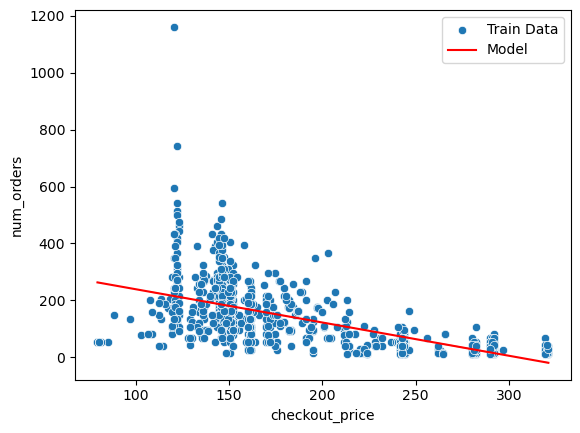

In [33]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

sns.scatterplot(
    x="checkout_price", y="num_orders", data=train_data, label="Train Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)

In [34]:
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 7478.46
Test MSE: 8253.62


In [35]:
model.coef_

array([-1.16828049])

In [36]:
from copy import deepcopy
coefs = [
    -2.0,
    -1.7,
    -1.4,
    -1.16981158,
    -1.16828049,
    -0.99,
    -0.97,
    -0.84,
    -0.64,
    -0.5,
    -0.2,
    0.01,
    0.2,
    0.45,
    0.76,
    0.99,
    1.2,
]

models = []
for coef in coefs:
    new_model = deepcopy(model)
    new_model.coef_ = np.array([coef])
    models.append(new_model)

for i in range(len(models)):
    test_data[f"exp{i}"] = models[i].predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

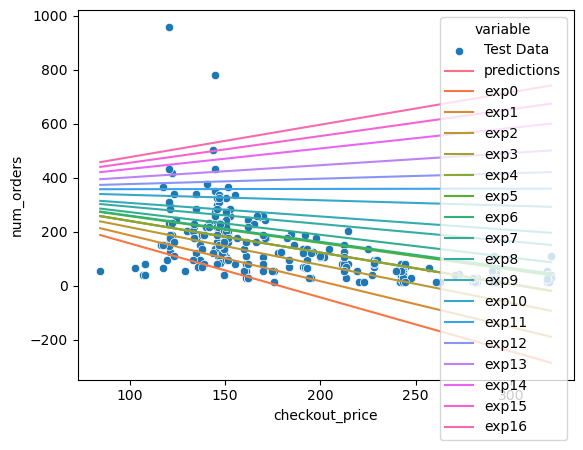

In [37]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="value", hue="variable", data=pd.melt(test_data.drop(["num_orders"], axis=1), ["checkout_price"])
)

Loss for model 0: 36741.77
Loss for model 1: 19589.22
Loss for model 2: 10196.68
Loss for model 3: 8251.26
Loss for model 4: 8253.62
Loss for model 5: 9909.88
Loss for model 6: 10266.64
Loss for model 7: 13426.29
Loss for model 8: 21132.62
Loss for model 9: 28579.14
Loss for model 10: 50226.66
Loss for model 11: 69997.13
Loss for model 12: 91161.15
Loss for model 13: 123750.77
Loss for model 14: 171646.00
Loss for model 15: 212535.58
Loss for model 16: 253853.02


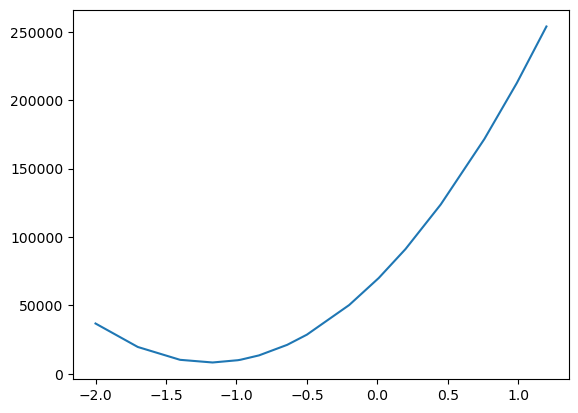

In [38]:
losses = []
for i, model in enumerate(models):
    loss = mean_squared_error(test_data["num_orders"], test_data[f"exp{i}"])
    losses.append(loss)
    print(f"Loss for model {i}: {loss:.2f}")
plt.plot(np.array(coefs), np.array(losses), label = "MSE")

<Axes: xlabel='checkout_price', ylabel='num_orders'>

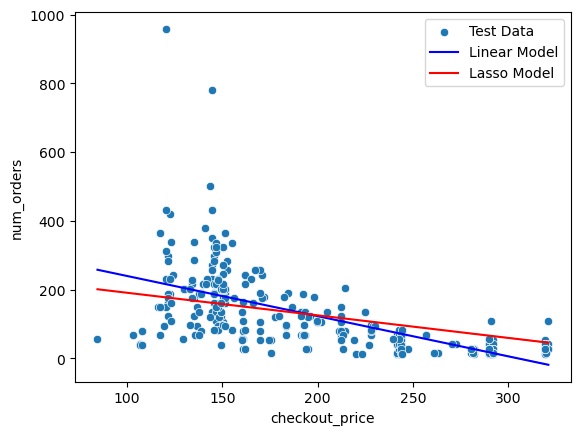

In [39]:
from sklearn.linear_model import Ridge, Lasso

model_lasso = Lasso(alpha=2_000).fit(x, y)

test_data_lasso = test_data[:]

x_test = test_data_lasso["checkout_price"].to_numpy().reshape(-1, 1)
test_data_lasso["predictions"] = model_lasso.predict(x_test)

sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data_lasso, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="blue", label="Linear Model"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data_lasso, color="red", label="Lasso Model")


In [40]:
mean_squared_error_test_lasso = mean_squared_error(
    test_data_lasso["num_orders"], test_data_lasso["predictions"]
)
print(f"Test MSE Lasso: {mean_squared_error_test_lasso:.2f}")
# Lasso tends to shrink some coefficients to zero, effectively performing feature selection.

Test MSE Lasso: 8932.53


In [41]:
model_lasso.coef_, model_lasso.intercept_

(array([-0.65656603]), np.float64(256.34780129463945))

Loss for Lasso model 0: 78521.18
Loss for Lasso model 1: 49486.35
Loss for Lasso model 2: 28211.54
Loss for Lasso model 3: 17148.91
Loss for Lasso model 4: 17090.62
Loss for Lasso model 5: 11685.62
Loss for Lasso model 6: 11250.24
Loss for Lasso model 7: 9260.89
Loss for Lasso model 8: 9045.71
Loss for Lasso model 9: 10947.17
Loss for Lasso model 10: 20712.41
Loss for Lasso model 11: 32165.29
Loss for Lasso model 12: 45803.86
Loss for Lasso model 13: 68491.59
Loss for Lasso model 14: 104108.47
Loss for Lasso model 15: 135888.31
Loss for Lasso model 16: 168888.15


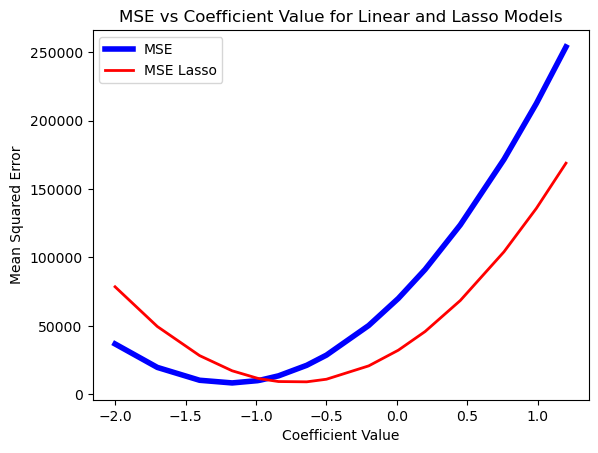

In [42]:
coefs = [-2.0, -1.7, -1.4, -1.16981158, -1.16828049, -0.99, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

models_lasso = []
for coef in coefs:
    new_model = deepcopy(model_lasso)
    new_model.coef_ = np.array([coef])
    models_lasso.append(new_model)

for i in range(len(models_lasso)):
    test_data_lasso[f"exp{i}"] = models_lasso[i].predict(x_test)

losses_lasso = []
for i in range(len(models_lasso)):
    mse = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp{i}"])
    losses_lasso.append(mse)
    print(f"Loss for Lasso model {i}: {mse:.2f}")

plt.plot(np.array(coefs), np.array(losses), label="MSE", color='blue', linewidth=4 )
plt.plot(np.array(coefs), np.array(losses_lasso), label="MSE Lasso", color='red', linewidth=2)
plt.xlabel("Coefficient Value")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Coefficient Value for Linear and Lasso Models")
plt.legend()
plt.show()

Loss for Lasso model 0 with alpha 0: 36741.77
Loss for Lasso model 1 with alpha 1: 19589.22
Loss for Lasso model 2 with alpha 2: 10196.68
Loss for Lasso model 3 with alpha 3: 8251.26
Loss for Lasso model 4 with alpha 4: 8253.62
Loss for Lasso model 5 with alpha 5: 9909.88
Loss for Lasso model 6 with alpha 6: 10266.64
Loss for Lasso model 7 with alpha 7: 13426.29
Loss for Lasso model 8 with alpha 8: 21132.62
Loss for Lasso model 9 with alpha 9: 28579.14
Loss for Lasso model 10 with alpha 10: 50226.66
Loss for Lasso model 11 with alpha 11: 69997.13
Loss for Lasso model 12 with alpha 12: 91161.15
Loss for Lasso model 13 with alpha 13: 123750.77
Loss for Lasso model 14 with alpha 14: 171646.00
Loss for Lasso model 15 with alpha 15: 212535.58
Loss for Lasso model 16 with alpha 16: 253853.02
Loss for Lasso model 0 with alpha 0: 45313.21
Loss for Lasso model 1 with alpha 1: 25190.09
Loss for Lasso model 2 with alpha 2: 12826.98
Loss for Lasso model 3 with alpha 3: 8602.26
Loss for Lasso model

/home/sergio/anaconda3/envs/conda_env_example/lib/python3.11/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/sergio/anaconda3/envs/conda_env_example/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/sergio/anaconda3/envs/conda_env_example/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.586e+06, tolerance: 1.229e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the sol

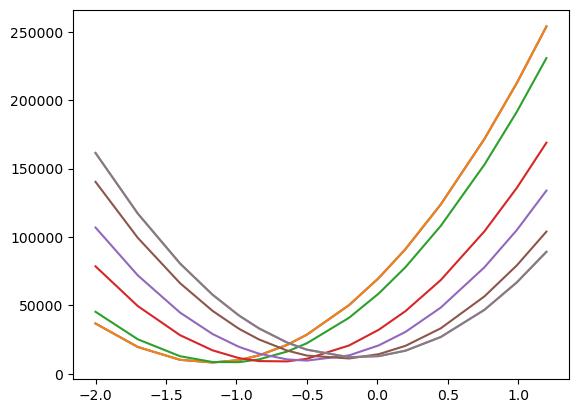

In [43]:
plt.plot(np.array(coefs), np.array(losses), label="MSE")

losses_lasso_all = [losses]

for i in [0, 500, 2000, 3000, 4000, 5000, 10_000]:
    model_lasso = Lasso(alpha=i).fit(x, y)

    x_test = test_data_lasso["checkout_price"].to_numpy().reshape(-1, 1)
    test_data_lasso["predictions"] = model_lasso.predict(x_test)
    models_lasso = []
    for coef in coefs:
        new_model = deepcopy(model_lasso)
        new_model.coef_ = np.array([coef])
        models_lasso.append(new_model)

    for i in range(len(models_lasso)):
        test_data_lasso[f"exp{i}"] = models_lasso[i].predict(x_test)

    losses_lasso = []
    for i, model in enumerate(models_lasso):
        mse = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp{i}"])
        losses_lasso.append(mse)
        print(f"Loss for Lasso model {i} with alpha {i}: {mse:.2f}")

    losses_lasso_all.append(losses_lasso)
    plt.plot(np.array(coefs), np.array(losses_lasso), label="MSE")


In [44]:
losses_lasso_all

[[36741.771308998075,
  19589.21855864078,
  10196.679468058483,
  8251.262404401647,
  8253.617667304006,
  9909.87591293214,
  10266.641703798154,
  13426.287490902867,
  21132.619351443,
  28579.144154961592,
  50226.6597034793,
  69997.12871500783,
  91161.14612781958,
  123750.7680303291,
  171646.00125242394,
  212535.58371341648,
  253853.02398692025],
 [36741.77130899811,
  19589.2185586408,
  10196.679468058494,
  8251.262404401647,
  8253.617667304004,
  9909.87591293213,
  10266.641703798145,
  13426.28749090285,
  21132.61935144298,
  28579.14415496157,
  50226.65970347925,
  69997.12871500776,
  91161.14612781952,
  123750.76803032905,
  171646.00125242388,
  212535.5837134164,
  253853.0239869201],
 [45313.2070759442,
  25190.085294361255,
  12826.977172553314,
  8602.258136233937,
  8589.452704009564,
  8480.395941418587,
  8639.123796869559,
  10511.52300377649,
  16237.475510166196,
  22297.73476577949,
  40974.68128307154,
  58665.75197274211,
  77948.40899911096,
  1

In [45]:
#   8251.262404401647

Test MSE Ridge: 8253.21


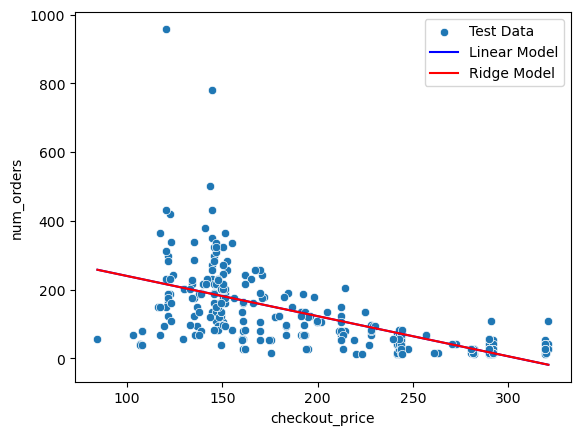

In [46]:
model_ridge = Ridge(alpha=2_000).fit(x, y)

test_data_ridge = test_data[:]

x_test = test_data_ridge["checkout_price"].to_numpy().reshape(-1, 1)
test_data_ridge["predictions"] = model_ridge.predict(x_test)

sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data_ridge, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="blue", label="Linear Model"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data_ridge, color="red", label="Ridge Model"
)

mean_squared_error_test_ridge = mean_squared_error(
    test_data_ridge["num_orders"], test_data_ridge["predictions"]
)
print(f"Test MSE Ridge: {mean_squared_error_test_ridge:.2f}")

Loss for Ridge model 0 with alpha 0: 36741.77
Loss for Ridge model 1 with alpha 1: 19589.22
Loss for Ridge model 2 with alpha 2: 10196.68
Loss for Ridge model 3 with alpha 3: 8251.26
Loss for Ridge model 4 with alpha 4: 8253.62
Loss for Ridge model 5 with alpha 5: 9909.88
Loss for Ridge model 6 with alpha 6: 10266.64
Loss for Ridge model 7 with alpha 7: 13426.29
Loss for Ridge model 8 with alpha 8: 21132.62
Loss for Ridge model 9 with alpha 9: 28579.14
Loss for Ridge model 10 with alpha 10: 50226.66
Loss for Ridge model 11 with alpha 11: 69997.13
Loss for Ridge model 12 with alpha 12: 91161.15
Loss for Ridge model 13 with alpha 13: 123750.77
Loss for Ridge model 14 with alpha 14: 171646.00
Loss for Ridge model 15 with alpha 15: 212535.58
Loss for Ridge model 16 with alpha 16: 253853.02
Loss for Ridge model 0 with alpha 0: 36751.45
Loss for Ridge model 1 with alpha 1: 19595.28
Loss for Ridge model 2 with alpha 2: 10199.12
Loss for Ridge model 3 with alpha 3: 8250.93
Loss for Ridge model

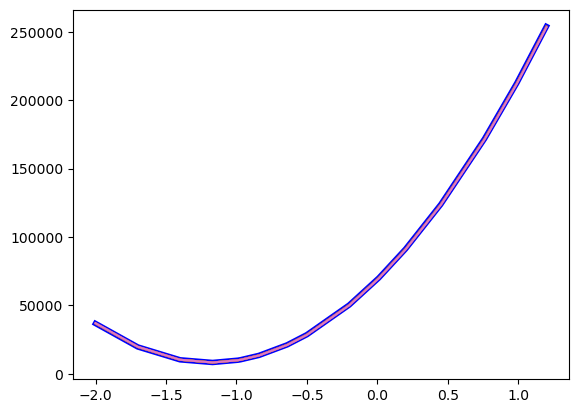

In [47]:
plt.plot(np.array(coefs), np.array(losses), label="MSE", color='blue', linewidth=4 )

losses_ridge_all = []

for i in [0, 500, 2000, 3000, 4000, 5000, 10_000]:
    model_ridge = Ridge(alpha=i).fit(x, y)

    x_test = test_data_ridge["checkout_price"].to_numpy().reshape(-1, 1)
    test_data_ridge["predictions"] = model_ridge.predict(x_test)
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)

    for i in range(len(models_ridge)):
        test_data_ridge[f"exp{i}"] = models_ridge[i].predict(x_test)

    losses_ridge = []
    for i, model in enumerate(models_ridge):
        mse = mean_squared_error(test_data_ridge["num_orders"], test_data_ridge[f"exp{i}"])
        losses_ridge.append(mse)
        print(f"Loss for Ridge model {i} with alpha {i}: {mse:.2f}")

    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs), np.array(losses_ridge), label="MSE")

In [48]:
losses_ridge_all

[[36741.7713089981,
  19589.21855864079,
  10196.679468058488,
  8251.262404401647,
  8253.617667304004,
  9909.875912932135,
  10266.641703798148,
  13426.287490902858,
  21132.61935144299,
  28579.14415496158,
  50226.65970347928,
  69997.1287150078,
  91161.14612781955,
  123750.76803032907,
  171646.00125242388,
  212535.58371341642,
  253853.02398692016],
 [36751.45215659599,
  19595.281059035846,
  10199.123621250701,
  8250.930218841746,
  8253.267015026708,
  9907.374991613795,
  10263.899559332951,
  13421.977395983096,
  21125.897025054663,
  28570.733266545263,
  50214.63046786011,
  69982.56663634663,
  91144.29242926325,
  123730.89904243709,
  171622.39330575563,
  212509.2017005593,
  253824.10913102105],
 [36780.49031864473,
  19613.46996854739,
  10206.46327822505,
  8249.945301483702,
  8252.226727061774,
  9899.887336787311,
  10255.688621003987,
  13409.065114888013,
  21105.751908934784,
  28545.525165908028,
  50178.57311468568,
  69938.91480639616,
  91093.769406

In [49]:
# 8251.262404401647,

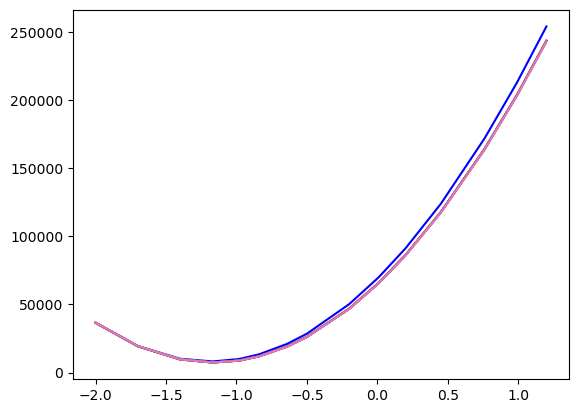

In [50]:
plt.plot(np.array(coefs), np.array(losses), label="MSE", color="blue")

losses_ridge_all = []

train_data_ridge = train_data[:]

for i in [0, 500, 2000, 3000, 4000, 5000, 10_000]:
    model_ridge = Ridge(alpha=i).fit(x, y)

    train_data_ridge["predictions"] = model_ridge.predict(x)
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)

    for i in range(len(models_ridge)):
        train_data_ridge[f"exp{i}"] = models_ridge[i].predict(x)

    losses_ridge = []
    for i, model in enumerate(models_ridge):
        mse = mean_squared_error(
            train_data_ridge["num_orders"], train_data_ridge[f"exp{i}"]
        )
        losses_ridge.append(mse)

    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs), np.array(losses_ridge), label="MSE")

### Hyperparameter tuning

Examples

- $–ü–∞—Ä–∞–º–µ—Ç–µ—Ä —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ñ \lambda$
- –°—Ç—É–ø—ñ–Ω—å –ø–æ–ª—ñ–Ω–æ–º–∞ –≤ –∑–∞–¥–∞—á—ñ —Ä–µ–≥—Ä–µ—Å—ñ—ó –∑ —Å—ñ–º–µ–π—Å—Ç–≤–æ–º –∞–ª–≥–æ—Ä–∏—Ç–º—ñ–≤, –∑–∞–¥–∞–Ω–∏–º –±–µ–∑–ª—ñ—á—á—é –ø–æ–ª—ñ–Ω–æ–º—ñ–≤ –¥–µ—è–∫–æ–≥–æ —Å—Ç—É–ø–µ–Ω—è
- learning rate
- ...

<p align="center">
  <img src="./data/traing_data-validation-test.avif" alt="Training data / Validation / test" width="500"/>
</p>

test ~ 15%, validation = (100% - 15%) * 10%, rest - training data

In [57]:
m = LinearRegression().fit(x, y)
y_test = test_data["num_orders"].to_numpy()
m.score(x_test, y_test)  # the coefficient of determination of the prediction(R^2 score).

0.34950196296612424

In [58]:
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit

m = LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(m, x, y, cv=cv)
scores, np.mean(scores), np.std(scores)

(array([0.46780125, 0.44824487, 0.38389073, 0.44793372, 0.40478883]),
 np.float64(0.430531881163032),
 np.float64(0.031124530126542944))

In [59]:
m = Ridge(3_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.37807555, 0.54123965, 0.4183379 , 0.33134929, 0.42579396]),
 np.float64(0.41895926930435035),
 np.float64(0.06978048032155662))

In [60]:
m = Ridge(5_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.37810066, 0.54126547, 0.41834641, 0.33125056, 0.42595321]),
 np.float64(0.41898326264774644),
 np.float64(0.06981452591860633))

In [61]:
m = Lasso(2_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.31863809, 0.43776207, 0.34249314, 0.21777693, 0.40221298]),
 np.float64(0.3437766432028767),
 np.float64(0.07583875903024016))

In [62]:
m = Lasso(4_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.10673551, 0.09221888, 0.10283705, 0.01431282, 0.12882813]),
 np.float64(0.08898647788946898),
 np.float64(0.0391939477223673))

In [63]:
import sklearn.metrics


m = LinearRegression().fit(x, y)
x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
y_test = test_data["num_orders"].to_numpy()
pred = m.predict(x_test)
sklearn.metrics.r2_score(y_test, pred)

0.34950196296612424